In [ ]:
pip install easyocr

In [ ]:
pip install transformers

In [ ]:
pip install timm

In [4]:
import numpy as np
import cv2
import datetime
import easyocr
import pandas as pd
from google.colab.patches import cv2_imshow
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image


In [5]:
# класс для выделения таблицы из картинки extract-table-from-image-python
# https://github.com/livefiredev/ocr-extract-table-from-image-python/blob/main/main.py
class TableExtractor:

    def __init__(self, image_path):
        self.image_path = image_path

    def execute(self):
        self.read_image()
        self.store_process_image("0_original.jpg", self.image)
        self.convert_image_to_grayscale()
        self.store_process_image("1_grayscaled.jpg", self.grayscale_image)
        self.threshold_image()
        self.store_process_image("3_thresholded.jpg", self.thresholded_image)
        self.invert_image()
        self.store_process_image("4_inverteded.jpg", self.inverted_image)
        self.dilate_image()
        self.store_process_image("5_dialateded.jpg", self.dilated_image)
        self.find_contours()
        self.store_process_image("6_all_contours.jpg", self.image_with_all_contours)
        self.filter_contours_and_leave_only_rectangles()
        self.store_process_image("7_only_rectangular_contours.jpg", self.image_with_only_rectangular_contours)
        self.find_largest_contour_by_area()
        self.store_process_image("8_contour_with_max_area.jpg", self.image_with_contour_with_max_area)
        self.order_points_in_the_contour_with_max_area()
        self.store_process_image("9_with_4_corner_points_plotted.jpg", self.image_with_points_plotted)
        self.calculate_new_width_and_height_of_image()
        self.apply_perspective_transform()
        self.store_process_image("10_perspective_corrected.jpg", self.perspective_corrected_image)
        self.add_10_percent_padding()
        self.store_process_image("11_perspective_corrected_with_padding.jpg", self.perspective_corrected_image_with_padding)
        return self.perspective_corrected_image_with_padding

    def read_image(self):
        self.image = cv2.imread(self.image_path)

    def convert_image_to_grayscale(self):
        self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def blur_image(self):
        self.blurred_image = cv2.blur(self.grayscale_image, (5, 5))

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def dilate_image(self):
        self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=5)

    def find_contours(self):
        self.contours, self.hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.image_with_all_contours = self.image.copy()
        cv2.drawContours(self.image_with_all_contours, self.contours, -1, (0, 255, 0), 3)

    def filter_contours_and_leave_only_rectangles(self):
        self.rectangular_contours = []
        for contour in self.contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:
                self.rectangular_contours.append(approx)
        self.image_with_only_rectangular_contours = self.image.copy()
        cv2.drawContours(self.image_with_only_rectangular_contours, self.rectangular_contours, -1, (0, 255, 0), 3)

    def find_largest_contour_by_area(self):
        max_area = 0
        self.contour_with_max_area = None
        for contour in self.rectangular_contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                self.contour_with_max_area = contour
        self.image_with_contour_with_max_area = self.image.copy()
        cv2.drawContours(self.image_with_contour_with_max_area, [self.contour_with_max_area], -1, (0, 255, 0), 3)

    def order_points_in_the_contour_with_max_area(self):
        self.contour_with_max_area_ordered = self.order_points(self.contour_with_max_area)
        self.image_with_points_plotted = self.image.copy()
        for point in self.contour_with_max_area_ordered:
            point_coordinates = (int(point[0]), int(point[1]))
            self.image_with_points_plotted = cv2.circle(self.image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)

    def calculate_new_width_and_height_of_image(self):
        existing_image_width = self.image.shape[1]
        existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)

        distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[1])
        distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[3])

        aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right

        self.new_image_width = existing_image_width_reduced_by_10_percent
        self.new_image_height = int(self.new_image_width * aspect_ratio)

    def apply_perspective_transform(self):
        pts1 = np.float32(self.contour_with_max_area_ordered)
        pts2 = np.float32([[0, 0], [self.new_image_width, 0], [self.new_image_width, self.new_image_height], [0, self.new_image_height]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        self.perspective_corrected_image = cv2.warpPerspective(self.image, matrix, (self.new_image_width, self.new_image_height))

    def add_10_percent_padding(self):
        image_height = self.image.shape[0]
        padding = int(image_height * 0.1)
        self.perspective_corrected_image_with_padding = cv2.copyMakeBorder(self.perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    def draw_contours(self):
        self.image_with_contours = self.image.copy()
        cv2.drawContours(self.image_with_contours,  [ self.contour_with_max_area ], -1, (0, 255, 0), 1)

    def calculateDistanceBetween2Points(self, p1, p2):
        dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
        return dis

    def order_points(self, pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # return the ordered coordinates
        return rect

    def store_process_image(self, file_name, image):
        path = "./process_images/table_extractor/" + file_name
        cv2.imwrite(path, image)

In [6]:
# Нахождение таблицы с помощью предобученной модели
# https://huggingface.co/docs/transformers/main/en/model_doc/table-transformer

PRETRAINED_MODEL = "microsoft/table-transformer-detection"

In [7]:
file_path = "233749 .jpg"
csv_path = '233749.csv'
image = Image.open(file_path).convert("RGB")

# границы таблицы будем хранить в переменной `box`. Исходное значение переменной "0"
box = 0

In [8]:
# выделяем таблицу с помощью PRETRAINED MODEL
try:
  image_processor = AutoImageProcessor.from_pretrained(PRETRAINED_MODEL)
  model = TableTransformerForObjectDetection.from_pretrained(PRETRAINED_MODEL)

  inputs = image_processor(images=image, return_tensors="pt")
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
  target_sizes = torch.tensor([image.size[::-1]])
  results = image_processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[
    0
  ]

  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
  box
except:
  pass

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected table with confidence 0.812 at location [345.13, 2734.86, 2848.7, 3452.26]


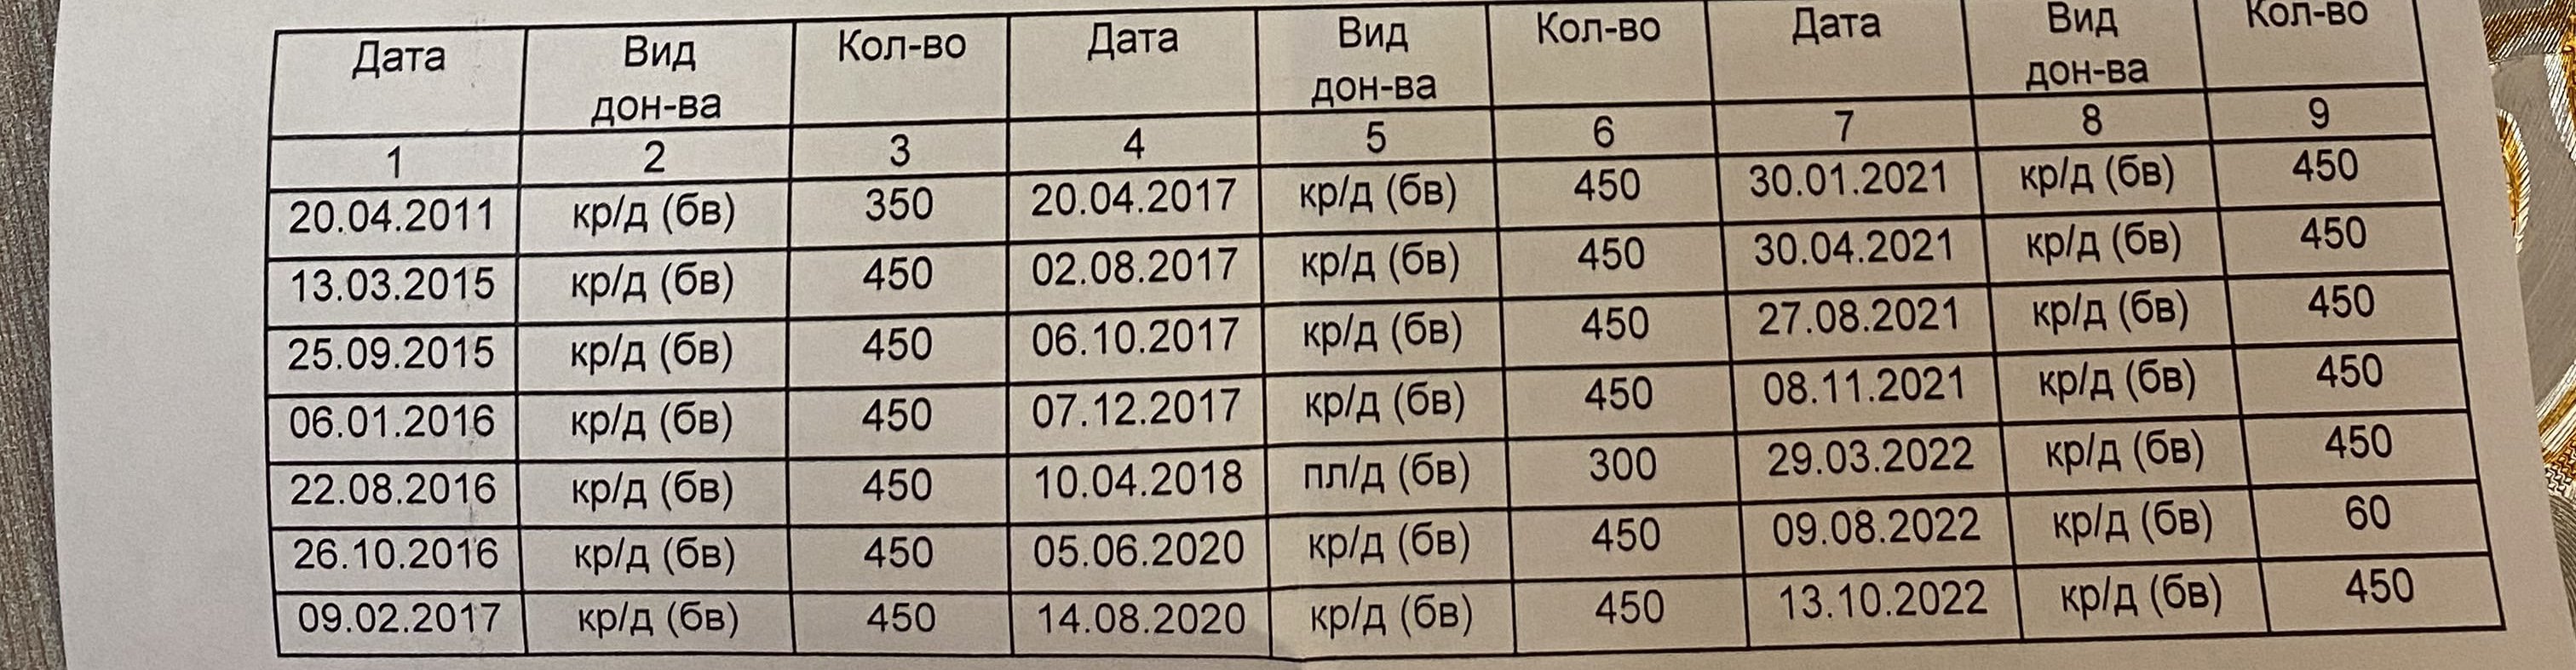

In [9]:
# если предобученная модель PRETRAINED_MODEL не смогла выделить таблицу,
# то пробуем выделить таблицу другим способом - с помощью класса TableExtractor:
if box == 0:
  table_extractor = TableExtractor(file_path)
  corrected_image = table_extractor.execute()
  # если удалось обнаружить таблицу, записываем ее в файл `img.jpg`
  # и вырезаем из исходной картинки область по контуру найденной таблицы
  cv2_imshow(corrected_image)
  isWritten = cv2.imwrite('img.jpg', corrected_image)
  image_cropped = Image.open('img.jpg').convert("RGB")

else:
  # если таблицу получилось обнаружить с помощью предобученной модели, то вырезаем ее из исходной картинки.
  # Для этого определяем размер исходной картинки
  original_img_size = list(image.size)
  original_img_size
  # к границам найденной таблицы добавиляем отступы
  box_expanded = [0, box[1] - 20,original_img_size[0], box[3]+50]
  box_expanded
  # вырезаем из исходной картинки область по контуру найденной таблицы с отступами
  image_cropped = image.crop(box_expanded)

image_cropped




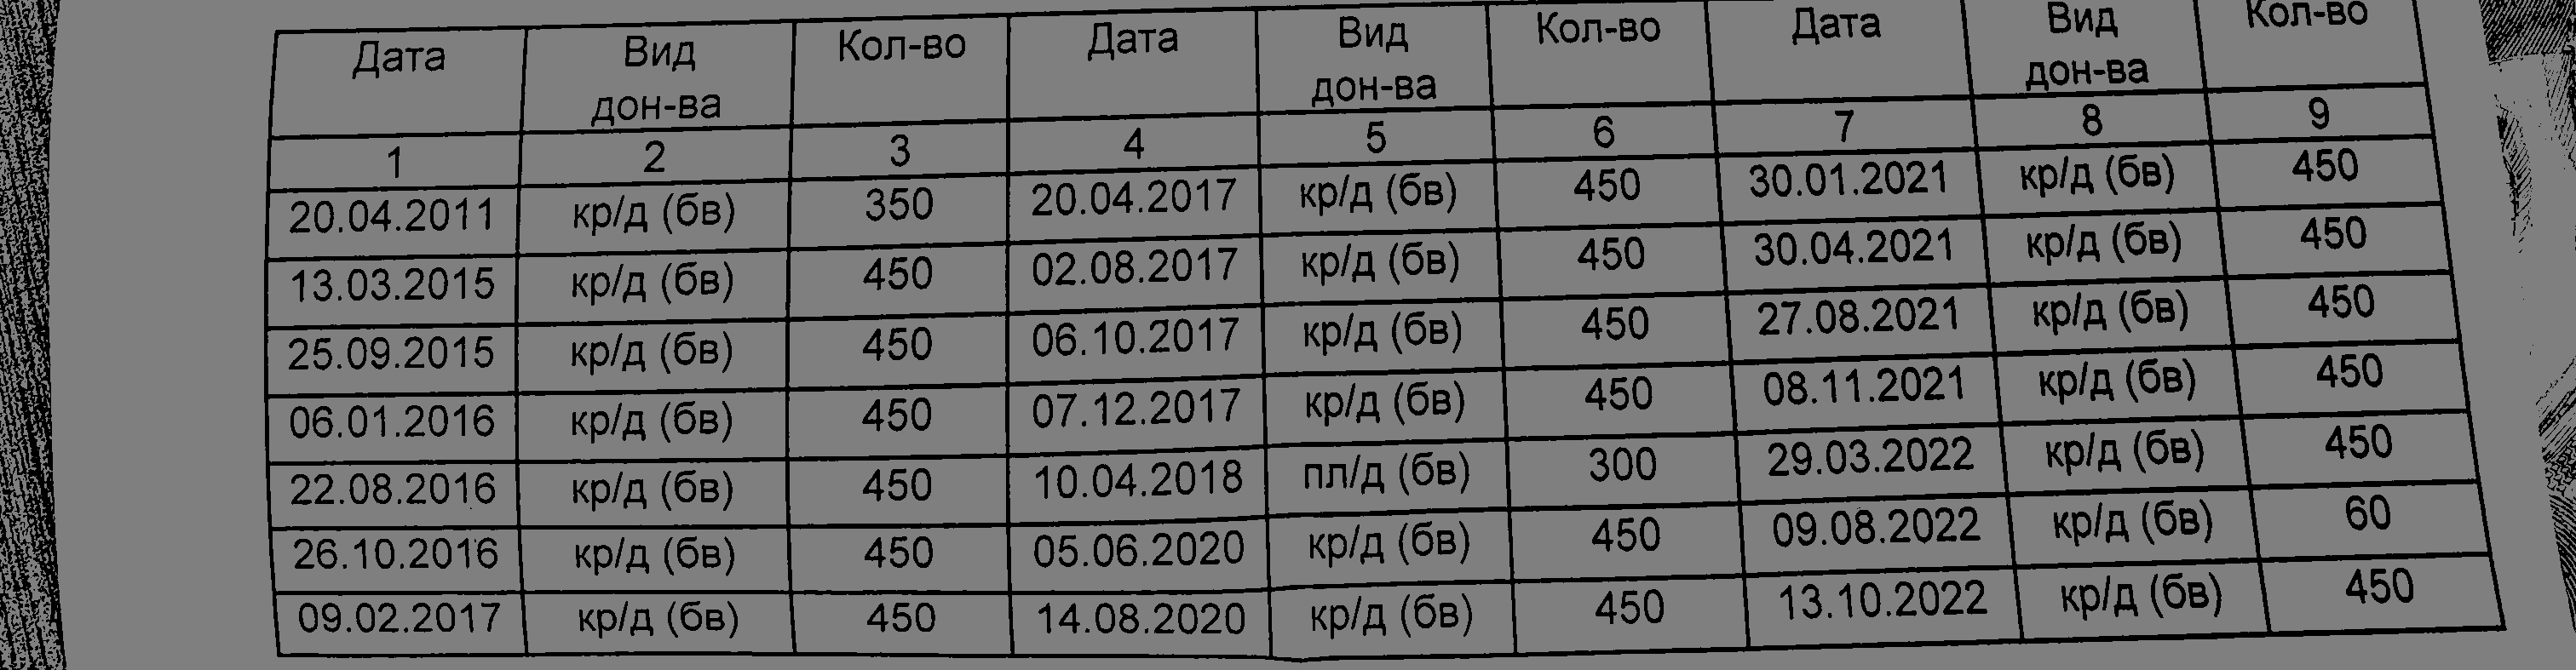

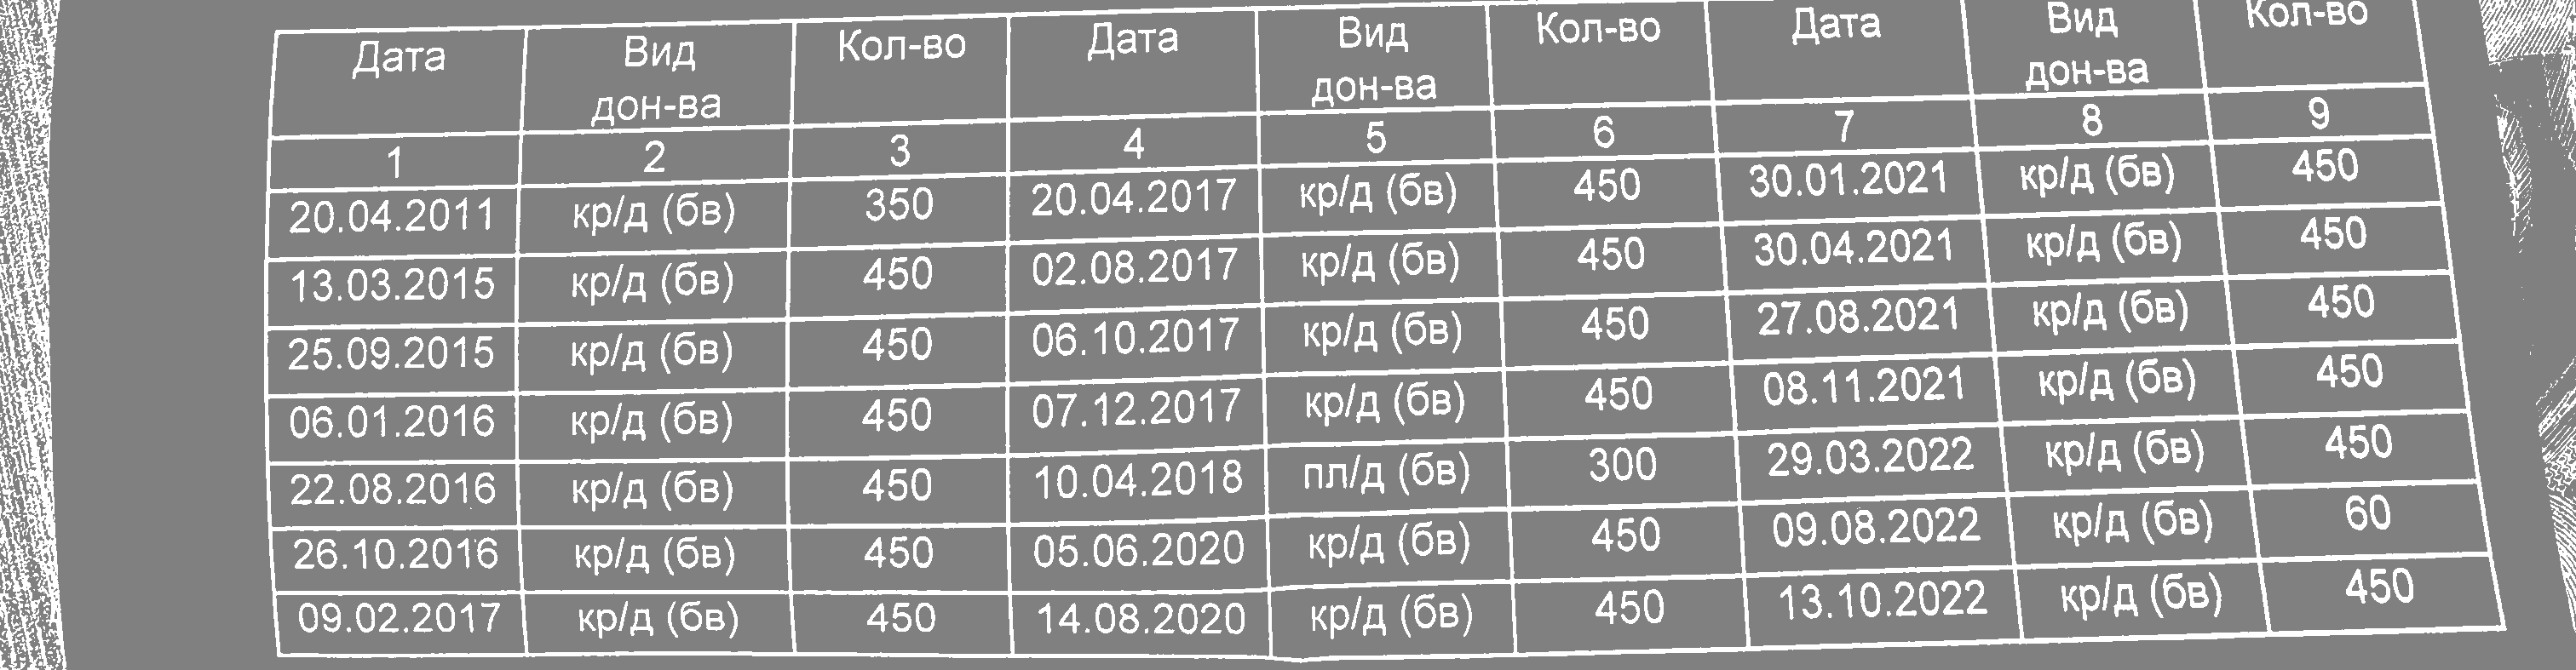

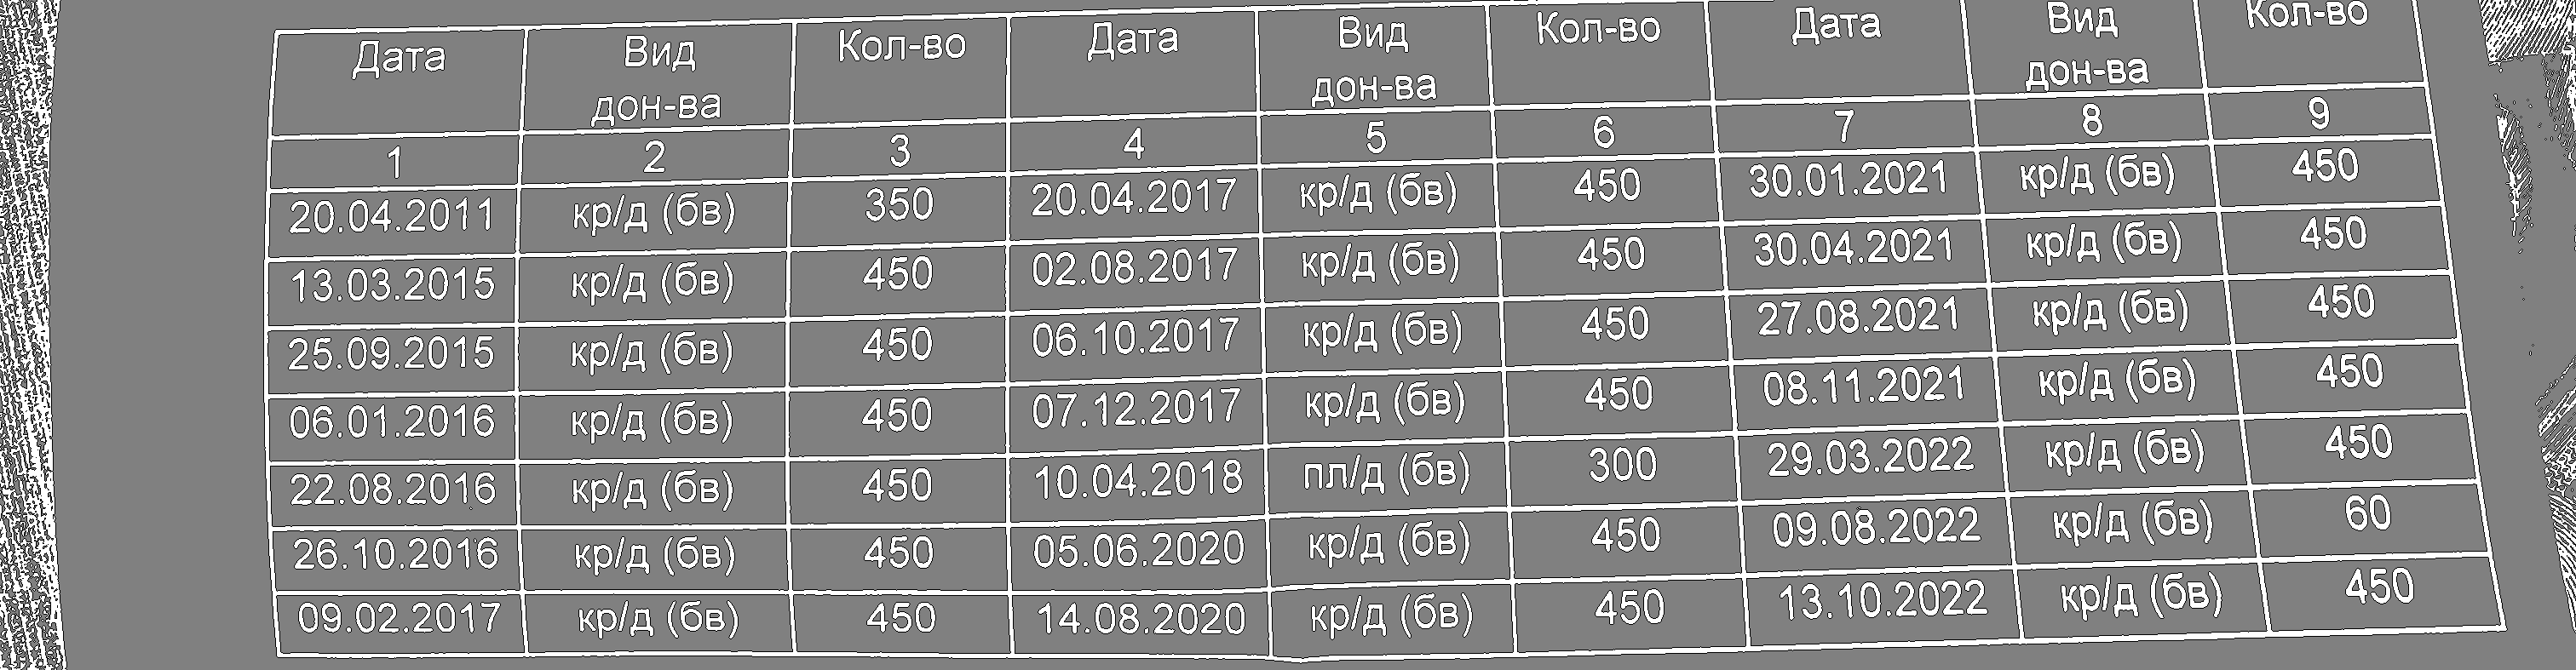

In [10]:
# обработка и преобразования выделенной области картинки с таблицей

table_np = np.array(image_cropped)

table_gray = cv2.cvtColor(table_np, cv2.COLOR_BGR2GRAY)

table_thresh = cv2.threshold(table_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
table_thresh_gaus = cv2.adaptiveThreshold(table_thresh,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
 cv2.THRESH_BINARY,11,2)
ret,table_thresh_trunc = cv2.threshold(table_thresh_gaus,127,255,cv2.THRESH_TRUNC)
table_bitwise = cv2.bitwise_not(src=table_thresh_trunc)

kernel1 = np.array([[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]])

identity = cv2.filter2D(src=table_bitwise, ddepth=-1, kernel=kernel1)

kernel3 = np.array([[0, -1,  0],
                   [-1,  5, -1],
                    [0, -1,  0]])

table_sharp = cv2.filter2D(src=identity, ddepth=-1, kernel=kernel3)

table_dilate = cv2.dilate(table_sharp, None, iterations=1)

cv2_imshow(table_thresh_trunc)
cv2_imshow(table_bitwise)
cv2_imshow(table_sharp)

In [11]:
reader = easyocr.Reader(['ru'])

In [12]:
%%time
result=reader.readtext(table_sharp)

CPU times: user 35.8 s, sys: 6.59 s, total: 42.3 s
Wall time: 1min 5s


In [13]:
# результат распознавания
df_result = pd.DataFrame(result, columns=['box', 'text', 'coef'])
display(df_result.tail(10))
df_result.info()

box        text      coef
70  [[2745, 574], [2813, 574], [2813, 630], [2745,...          60  0.999983
71   [[343, 700], [594, 700], [594, 750], [343, 750]]  09.02.2017  0.730592
72   [[670, 696], [876, 696], [876, 758], [670, 758]]   крИд (бв)  0.325874
73  [[1011, 700], [1107, 700], [1107, 750], [1011,...         450  0.999564
74  [[1208, 695], [1469, 695], [1469, 755], [1208,...  14.08.2020  0.946066
75  [[1530, 689], [1739, 689], [1739, 758], [1530,...   кр/д (бв)  0.603005
76  [[1867, 685], [1960, 685], [1960, 741], [1867,...         450  0.563781
77  [[2081, 671], [2342, 671], [2342, 735], [2081,...  13.10.2022  0.996169
78  [[2410, 664], [2621, 664], [2621, 740], [2410,...   кред (бв)  0.331289
79  [[2748, 659], [2841, 659], [2841, 715], [2748,...         450  0.999537

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   box     80 non-null     object 
 1   text    80 non-null     object 
 2   coef    80 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.0+ KB


In [14]:
# среднее значение коэффициента распознавания данных
df_result['coef'].mean()

0.787744335423487

In [15]:
# функция для создания таблицы с результатами распознавания

def create_df(df_result, region):
  df_new = pd.DataFrame(columns=['Класс крови', "Дата донации", "Дата добавления донации", "Тип донации"])

  for i in range(len(df_result)):
    if df_result['text'][i].lower() in ["крад (бв)", "крад (бь)", "кр/д (бв)", "крод (бв)",'крыд {.п]','кр; {бь]','кАд {чв}'\
                                        ,'к[д {ев)','кд (са}','#рд [ев)','р/д (бв)','кр/л |"")','#р/4 (бв)','кред (6а)'\
                                        , '#р/д (6а)','"р!д /бы)','каёд {6в 1','кр}я |(}','крад (ба)','крд (бв)','крад'\
                                        , 'кд(бв)','крод (бву','#р{д (бв}','#рд (бв)','#род (бв}','крид (бв)','кред (ба}'\
                                        , 'кргд (@в}','кр{д {бв)','кред (бв)','ко/д (бв)','#р/д (бв)','кр/д (бы)','кр{д (бв)'\
                                        , 'крзд (бв)','коод (бв)','жруд бв)','грд[бв)']:
      df_new.loc[len(df_new), ['Дата донации']] = df_result['text'][i-1]
      df_new.loc[len(df_new)-1, ['Класс крови']] = "Цельная кровь"
      df_new.loc[len(df_new)-1, ['Тип донации']] = 'Безвозмездно'
      df_new.loc[len(df_new)-1, ['Дата добавления донации']] = pd.to_datetime('today', dayfirst=True).normalize()
      df_new.loc[len(df_new)-1, ['Регион']] = region
    elif df_result['text'][i].lower() in ["плад (бв)", "плад (бь)", "пл/д (бв)", "плод (бв)",'пл#д (б9}','пд (6в)'\
                                          ,'"лд {бв)','плд {бв}','пэд {б8}','лпд {бв}','ппд (ба)','пф(бв)','плюд (бв)'\
                                          , 'плд (бв)']:
      df_new.loc[len(df_new), ['Дата донации']] = df_result['text'][i-1]
      df_new.loc[len(df_new)-1, ['Класс крови']] = "Плазма"
      df_new.loc[len(df_new)-1, ['Тип донации']] = 'Безвозмездно'
      df_new.loc[len(df_new)-1, ['Дата добавления донации']] = pd.to_datetime('today', dayfirst=True).normalize()
      df_new.loc[len(df_new)-1, ['Регион']] = region
    elif df_result['text'][i].lower() in ["тф (бв)","тф (бь)",'т/ф(бв)','таф(бв)','тфбв)','тоф(бв)','тф(бе)','тф(бв)','т/ф бв)'\
                                          , 'цд (бв)']:
      df_new.loc[len(df_new), ['Дата донации']] = df_result['text'][i-1]
      df_new.loc[len(df_new)-1, ['Класс крови']] = "Тромбоциты"
      df_new.loc[len(df_new)-1, ['Тип донации']] = 'Безвозмездно'
      df_new.loc[len(df_new)-1, ['Дата добавления донации']] = pd.to_datetime('today', dayfirst=True).normalize()
      df_new.loc[len(df_new)-1, ['Регион']] = region
    else:
      pass

  try:
        df_new['Дата донации']=df_new['Дата донации'].str.replace(',','.')
        df_new['Дата донации']=df_new['Дата донации'].str.replace(' ','.')
  except:
    pass


  return df_new

In [16]:
# применяем функцию построения таблицы из предсказанных/распознанных значений. Регион на данном этапе заполним значением "Россия"
df_pred = create_df(df_result, 'Россия')
display(df_pred.head(3))
df_pred.info()

Класс крови Дата донации Дата добавления донации   Тип донации  Регион
0  Цельная кровь   20.04.2017     2023-07-25 00:00:00  Безвозмездно  Россия
1  Цельная кровь   30.01.2021     2023-07-25 00:00:00  Безвозмездно  Россия
2  Цельная кровь   20.04.2011     2023-07-25 00:00:00  Безвозмездно  Россия

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Класс крови              21 non-null     object
 1   Дата донации             21 non-null     object
 2   Дата добавления донации  21 non-null     object
 3   Тип донации              21 non-null     object
 4   Регион                   21 non-null     object
dtypes: object(5)
memory usage: 1.5+ KB


In [17]:
# значение "Дата донации" в справках бывает в формате` dd.mm.yy` и `dd.mm.yyyy`.
# Применим проверку формата даты к таблице с распознанными данными, предварительно приведя дату донации к типу `datetime`

try:
  df_pred['Дата донации'] = pd.to_datetime(df_pred['Дата донации'], format='%d.%m.%y')
  df_pred = df_pred.sort_values(by='Дата донации').reset_index(drop=True)
except:
  pass
df_pred.head(2)

Класс крови Дата донации Дата добавления донации   Тип донации  Регион
0  Цельная кровь   20.04.2017     2023-07-25 00:00:00  Безвозмездно  Россия
1  Цельная кровь   30.01.2021     2023-07-25 00:00:00  Безвозмездно  Россия

In [18]:
try:
        df_pred['Дата донации'] = pd.to_datetime(df_pred['Дата донации'], errors='coerce', format='%d.%m.%Y', dayfirst=True)
                                                #infer_datetime_format=True)
        df_pred = df_pred.sort_values(by='Дата донации').reset_index(drop=True)
except:
    pass

df_pred.head(2)

Класс крови Дата донации Дата добавления донации   Тип донации  Регион
0  Цельная кровь   2011-04-20     2023-07-25 00:00:00  Безвозмездно  Россия
1  Цельная кровь   2015-03-13     2023-07-25 00:00:00  Безвозмездно  Россия

In [19]:
# датасет с правильными ответами
df_true = pd.read_csv(csv_path)
df_true.info()
display(df_true.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       21 non-null     int64 
 1   ID пользователя          21 non-null     int64 
 2   Класс крови              21 non-null     object
 3   Дата донации             21 non-null     object
 4   Дата добавления донации  21 non-null     object
 5   Тип донации              21 non-null     object
 6   Регион                   21 non-null     object
 7   Место стадчи             21 non-null     int64 
 8   Статус донации           21 non-null     object
 9   Есть справка             21 non-null     object
dtypes: int64(3), object(7)
memory usage: 1.8+ KB


ID  ID пользователя    Класс крови Дата донации  \
0  216498           233749  Цельная кровь   20.04.2011   
1  216497           233749  Цельная кровь   13.03.2015   
2  216496           233749  Цельная кровь   25.09.2015   

  Дата добавления донации   Тип донации  \
0              01.06.2023  Безвозмездно   
1              01.06.2023  Безвозмездно   
2              01.06.2023  Безвозмездно   

                                              Регион  Место стадчи  \
0  Россия, Ханты-Мансийский Автономный округ - Юг...           572   
1  Россия, Ханты-Мансийский Автономный округ - Юг...           572   
2  Россия, Ханты-Мансийский Автономный округ - Юг...           572   

  Статус донации Есть справка  
0        Принята           Да  
1        Принята           Да  
2        Принята           Да

In [20]:
# приводим формат даты донации в датасете с правильными ответами к формату `datetime` (и к тому же формату даты, что в предсказаниях)
df_true['Дата донации'] = pd.to_datetime(df_true['Дата донации'], format='%d.%m.%Y', dayfirst=True)

df_true['Дата донации'].head(3)


0   2011-04-20
1   2015-03-13
2   2015-09-25
Name: Дата донации, dtype: datetime64[ns]

In [21]:
# для проверки выводим количество совпадающих дат донации: правильных и предсказанных
df_pred['Дата донации'].isin(df_true['Дата донации']).value_counts ()

True    21
Name: Дата донации, dtype: int64

In [22]:
# считаем точность модели, сравнивая количество совпадающих дат по классу крови и типу донации
common = pd.merge(df_pred, df_true, on=['Дата донации','Класс крови','Тип донации'], how='inner')
accuracy = len(common)/len(df_true)
common.head(3)

Класс крови Дата донации Дата добавления донации_x   Тип донации  \
0  Цельная кровь   2011-04-20       2023-07-25 00:00:00  Безвозмездно   
1  Цельная кровь   2015-03-13       2023-07-25 00:00:00  Безвозмездно   
2  Цельная кровь   2015-09-25       2023-07-25 00:00:00  Безвозмездно   

  Регион_x      ID  ID пользователя Дата добавления донации_y  \
0   Россия  216498           233749                01.06.2023   
1   Россия  216497           233749                01.06.2023   
2   Россия  216496           233749                01.06.2023   

                                            Регион_y  Место стадчи  \
0  Россия, Ханты-Мансийский Автономный округ - Юг...           572   
1  Россия, Ханты-Мансийский Автономный округ - Юг...           572   
2  Россия, Ханты-Мансийский Автономный округ - Юг...           572   

  Статус донации Есть справка  
0        Принята           Да  
1        Принята           Да  
2        Принята           Да

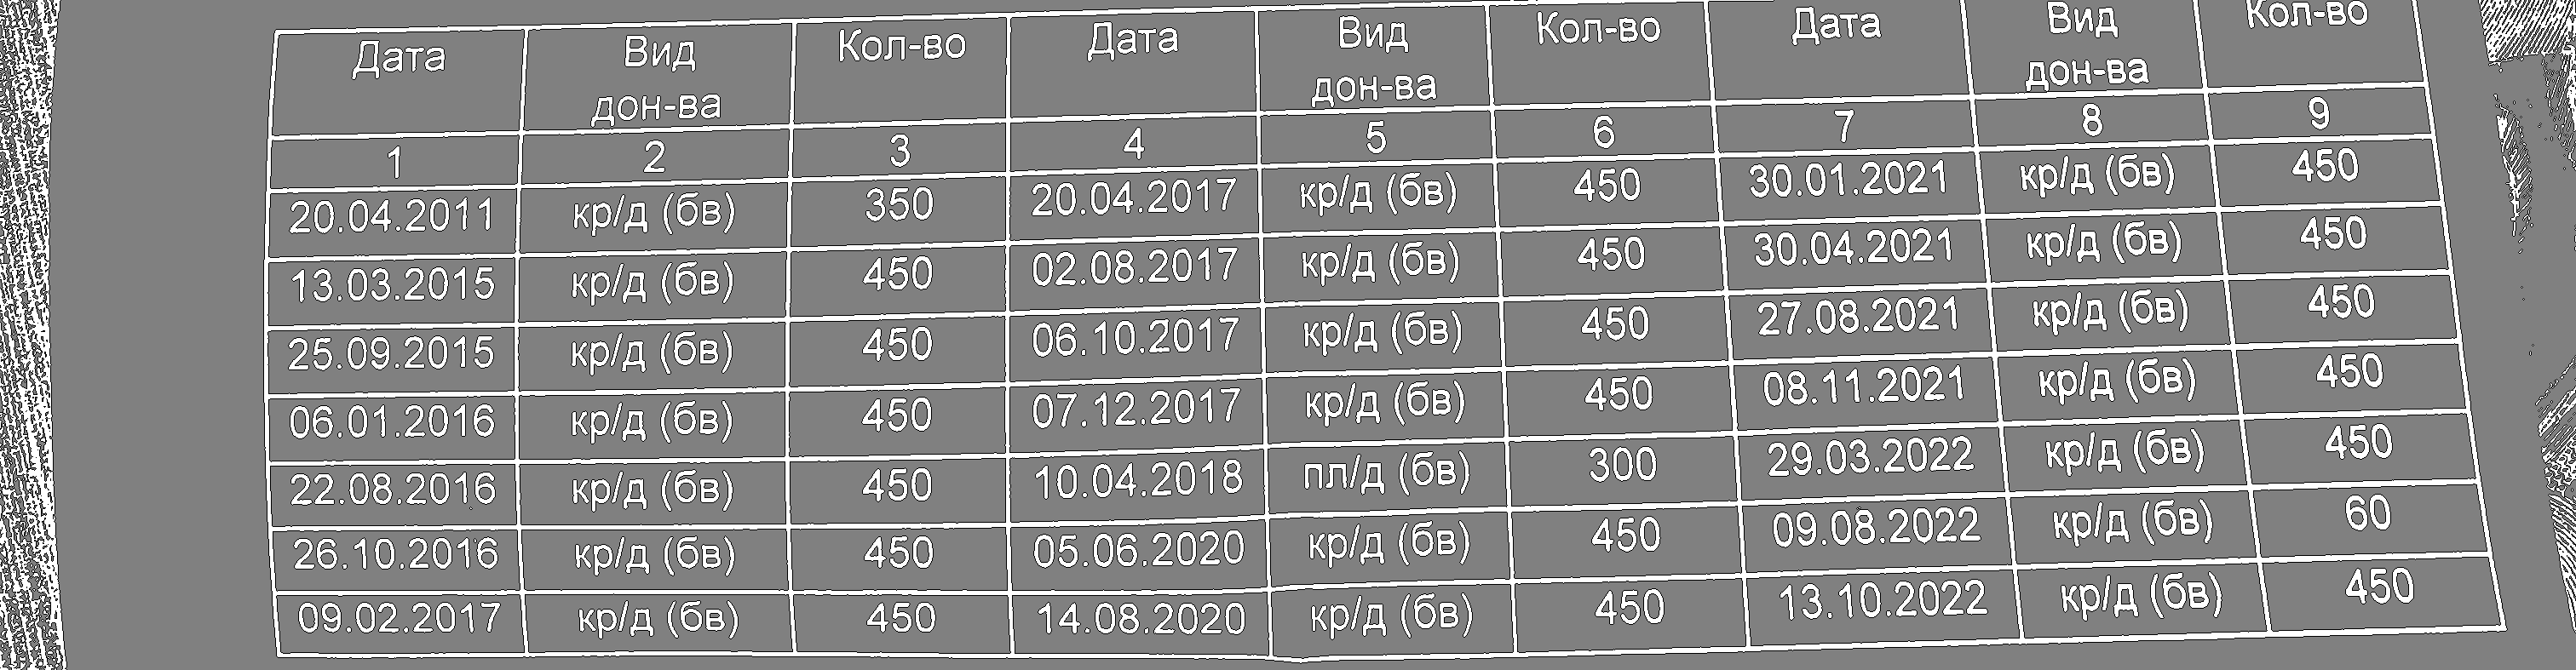

Класс крови Дата донации Дата добавления донации   Тип донации  Регион
0  Цельная кровь   2011-04-20     2023-07-25 00:00:00  Безвозмездно  Россия
1  Цельная кровь   2015-03-13     2023-07-25 00:00:00  Безвозмездно  Россия
2  Цельная кровь   2015-09-25     2023-07-25 00:00:00  Безвозмездно  Россия
3  Цельная кровь   2016-01-06     2023-07-25 00:00:00  Безвозмездно  Россия
4  Цельная кровь   2016-08-22     2023-07-25 00:00:00  Безвозмездно  Россия

Распознано: Цельная кровь    20
Плазма            1
Name: Класс крови, dtype: int64
В справке классов крови:                Класс крови
Цельная кровь           20
Плазма                   1
Точность распознавания 100.00%


In [23]:
# summary

# выводим обнаруженную таблицу
cv2_imshow(table_sharp)

# выводим распознанную таблицу, первые несколько строк
display(df_pred.head())
print("Распознано:", df_pred['Класс крови'].value_counts())
print('В справке классов крови:', df_true['Класс крови'].value_counts().to_frame())
print('Точность распознавания', '{:,.2%}'.format(accuracy))